[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/07_ulysses_compass.ipynb)

# 7. Ulysses' Compass

In [1]:
from io import StringIO
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from collections import namedtuple
import statsmodels.formula.api as smf

import random
import jax
import jax.numpy as jnp

from tensorflow_probability.substrates import jax as tfp
# import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from rethinking.data import RethinkingDataset

plt.rcParams['figure.figsize'] = [6, 4]

In [2]:
# global key generator for ch-07 notebook
key = tfp.util.SeedStream(7, salt="ch-07")

## 7.1 The problem with parameters

### 7.1.1 More parameters(almost) always improve fit

##### Code 7.1


Below is a dataset for average brain volumes and body masses for 7 hominin species

In [97]:
sppnames = [
    "afarensis",
    "africanus",
    "habilis",
    "boisei",
    "rudolfensis",
    "ergaster",
    "sapiens",
]
brainvolcc = jnp.array([438, 452, 612, 521, 752, 871, 1350])
masskg = jnp.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


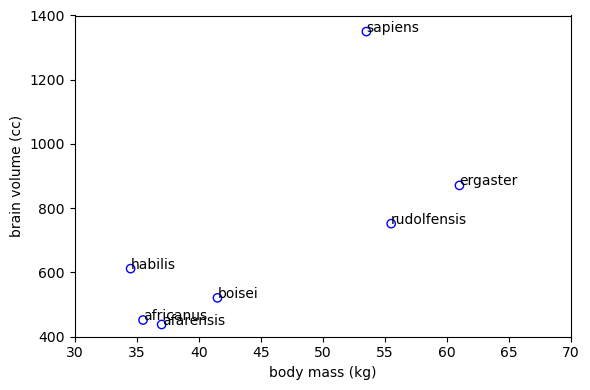

In [4]:
# Reproducing the figure in the book (there is no code fragment for this in R in the book)
plt.scatter(d.mass, d.brain, facecolors="none", edgecolors="b")
plt.gca().set(
    xlim=(30, 70), xlabel="body mass (kg)", ylim=(400, 1400), ylabel="brain volume (cc)"
)

for i in range(d.shape[0]):
    plt.annotate(d.species[i], (d.mass[i], d.brain[i]))

plt.tight_layout();

##### Code 7.2


Author talks about linear vs polynomial regression. He is of the opinion that most of the time polynomial regression is not a good idea (at least when used blindly). But why ?

In [98]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

Note - brain is not standardized as such because you can not have -ive brain

##### Code 7.3

Simplest model is the linear one and this is what we will start with

In [19]:
def model_71(mass_std):
    def _generator():
        alpha = yield tfd.Normal(loc=0.5, scale=1.0, name="alpha")
        beta = yield tfd.Normal(loc=0.0, scale=10.0, name="beta")
        # sigma = yield tfd.LogNormal(loc=0.0, scale=1.0, name="sigma")
        log_sigma = yield tfd.Normal(loc=0.0, scale=1.0, name="log_sigma")
        mu = alpha + beta * mass_std
        sigma = jnp.exp(log_sigma)
        yield tfd.Normal(loc=mu, scale=sigma, name="brain_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [20]:
jd_71 = model_71(d.mass_std.values)

In [21]:
jd_71_pd = jd_71.experimental_pin(brain_std=d.brain_std.values)

In [22]:
def target_log_prob_71(*states):
    return jd_71_pd.unnormalized_log_prob(states)

In [23]:
@jax.jit
def sample_post_71(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_71, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [24]:
num_chains = 4
init_state_71 = jd_71_pd.sample_unpinned(num_chains, seed=key())

In [12]:
post_71 = sample_post_71(init_state_71, key())

In [13]:
post_71_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_71._asdict().items()}
dict_71 = dict(posterior=post_71_dict)
idata_71 = az.from_dict(**dict_71)

In [14]:
az.summary(idata_71)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.527,0.114,0.318,0.750,0.002,0.002,2906.0,1802.0,1.0
beta,0.166,0.126,-0.064,0.396,0.003,0.002,2711.0,1511.0,1.0
log_sigma,-1.370,0.392,-2.102,-0.661,0.017,0.012,525.0,838.0,1.0


#### Code 7.4

OLS and Bayesian anti-essentialism. 

Use OLS for the above model. Author has used R's lm package so here we are using statsmodel (..sort of python counterpart to R's lm package) to do oridinary least square.

The OLS from the non bayesian statistics is going to provide the point estimates (which would to some extent correspond to the mean (mu) if flat priors are used). 

Note - In the text book you would see

```
m7.1_OLS <- lm( brain_std ~ mass_std , data=d ) 
post <- extract.samples( m7.1_OLS )
```

extract.samples( m7.1_OLS ) is in the source file https://github.com/rmcelreath/rethinking/blob/master/R/map-quap-class.r

Below I have replicated the code for extract.samples for (non-bayesian OLS) using statsmodel & tensorflow probabilty

In [15]:
# Use statsmodel OLS
m_7_1_OLS = smf.ols("brain_std ~ mass_std", data=d).fit()
m_7_1_OLS.params, m_7_1_OLS.cov_params()

(Intercept    0.528677
 mass_std     0.167118
 dtype: float64,
               Intercept      mass_std
 Intercept  4.980017e-03  2.473601e-11
 mass_std   2.473601e-11  5.810020e-03)

In [18]:
mu = jnp.array(m_7_1_OLS.params)
cov = jnp.array(m_7_1_OLS.cov_params())

In [19]:
# we can build a multivariate normal distribution using the mu & cov obtained
# from the non bayesian land
mvn = tfd.MultivariateNormalFullCovariance(loc=mu, covariance_matrix=cov)
posterior = mvn.sample(10000, seed=key())

##### Code 7.5


Variance explained or $R^2$ is defined as:

$R^2$ = 1 - $\frac{var(residuals)}{var(outcome)}$

In [86]:
post_pred_71 = jd_71.sample(500, value=post_71, seed=key())._asdict()['brain_std']

In [87]:
# (sample, draw, chain, obs)
post_pred_71.shape

(500, 1000, 4, 7)

In [91]:
# mean through [sample, draw, chain]
mu = post_pred_71.mean(axis=[0, 1, 2])

In [89]:
r = mu - d.brain_std.values

In [90]:
resid_var = jnp.var(r)
outcome_var = jnp.var(d.brain_std.values)
1 - (resid_var / outcome_var)

Array(0.5227264, dtype=float32)

##### fit sigma LogNormal directly

In [99]:
def model_71(mass_std):
    def _generator():
        alpha = yield tfd.Normal(loc=0.5, scale=1.0, name="alpha")
        beta = yield tfd.Normal(loc=0.0, scale=10.0, name="beta")
        sigma = yield tfd.LogNormal(loc=0.0, scale=1.0, name="sigma")
        mu = alpha + beta * mass_std
        yield tfd.Normal(loc=mu, scale=sigma, name="brain_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [100]:
jd_71 = model_71(d.mass_std.values)

In [101]:
jd_71_pd = jd_71.experimental_pin(brain_std=d.brain_std.values)

In [102]:
def target_log_prob_71(*states):
    return jd_71_pd.unnormalized_log_prob(states)

In [103]:
# @jax.jit
def sample_post_71(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_71, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [104]:
num_chains = 4
init_state_71 = jd_71_pd.sample_unpinned(num_chains, seed=key())

In [105]:
post_71 = sample_post_71(init_state_71, key())

In [106]:
post_71_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_71._asdict().items()}
dict_71 = dict(posterior=post_71_dict)
idata_71 = az.from_dict(**dict_71)

In [107]:
az.summary(idata_71)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.527,0.107,0.329,0.723,0.002,0.002,1963.0,1595.0,1.0
beta,0.167,0.118,-0.045,0.385,0.003,0.002,1540.0,1313.0,1.0
sigma,0.268,0.113,0.109,0.468,0.004,0.003,968.0,1107.0,1.0


##### Code 7.7

Building some more models to compare to m7.1

This one is a poymomial of second degree

In [24]:
def model_72(mass_std):
    def _generator():
        alpha = yield tfd.Normal(loc=0.5, scale=1.0, name="alpha")
        beta1 = yield tfd.Normal(loc=0.0, scale=10.0, name="beta1")
        beta2 = yield tfd.Normal(loc=0.0, scale=10.0, name="beta2")
        sigma = yield tfd.LogNormal(loc=0.0, scale=1.0, name="sigma")
        mu = alpha + beta1 * mass_std + beta2 * (mass_std**2)
        yield tfd.Normal(loc=mu, scale=sigma, name="brain_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [25]:
jd_72 = model_72(d.mass_std.values)

In [26]:
jd_72_pd = jd_72.experimental_pin(brain_std=d.brain_std.values)

In [27]:
def target_log_prob_72(*states):
    return jd_72_pd.unnormalized_log_prob(states)

In [28]:
@jax.jit
def sample_post_72(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_72, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [29]:
num_chains = 4
init_state_72 = jd_72_pd.sample_unpinned(num_chains, seed=key())

In [30]:
post_72 = sample_post_72(init_state_72, key())

In [31]:
post_72_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_72._asdict().items()}
dict_72 = dict(posterior=post_72_dict)
idata_72 = az.from_dict(**dict_72)

In [32]:
az.summary(idata_72)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.615,0.243,0.192,1.090,0.009,0.007,710.0,616.0,1.01
beta1,0.197,0.155,-0.098,0.493,0.004,0.003,1339.0,1571.0,1.00
beta2,-0.096,0.256,-0.560,0.411,0.010,0.007,683.0,524.0,1.01
sigma,0.305,0.154,0.120,0.590,0.008,0.005,533.0,692.0,1.01


In [33]:
d['mass_std_2'] = d['mass_std'].pow(2)
d['mass_std_3'] = d['mass_std'].pow(3)
d['mass_std_4'] = d['mass_std'].pow(4)
d['mass_std_5'] = d['mass_std'].pow(5)
d['mass_std_6'] = d['mass_std'].pow(6)

In [35]:
def gen_model(mass):
    ncol = mass.shape[1]
    def _generator():
        alpha = yield tfd.Normal(loc=0.5, scale=1.0, name="alpha")
        beta = yield tfd.Sample(
            tfd.Normal(loc=0.0, scale=10.0), sample_shape=ncol, name="beta")
        sigma = yield tfd.LogNormal(loc=0.0, scale=1.0, name="sigma")
        # match dims with output: (nobs,) not (1, nobs)
        mu = alpha + jnp.matmul(beta, mass.T) 
        yield tfd.Normal(loc=mu, scale=sigma, name="brain_std")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [36]:
mass_2 = d[['mass_std', 'mass_std_2']].to_numpy()

In [92]:
jd_72 = gen_model(mass_2)

In [93]:
jd_72_pd = jd_72.experimental_pin(brain_std=d.brain_std.values)

In [94]:
def target_log_prob_72(*states):
    return jd_72_pd.unnormalized_log_prob(states)

In [95]:
@jax.jit
def sample_post_72(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_72, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [96]:
num_chains = 4
init_state_72 = jd_72_pd.sample_unpinned(num_chains, seed=key())

In [97]:
post_72 = sample_post_72(init_state_72, key())

In [98]:
post_72_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_72._asdict().items()}
dict_72 = dict(posterior=post_72_dict,
               dims={"beta": ["coef"]},
               coords={"coef": ['1', '2']})
idata_72 = az.from_dict(**dict_72)

In [99]:
az.summary(idata_72)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.557,0.243,0.221,1.058,0.052,0.037,19.0,800.0,1.15
beta[1],-2.013,3.830,-8.643,0.388,1.907,1.461,7.0,4.0,1.53
beta[2],0.013,0.302,-0.512,0.372,0.105,0.077,10.0,703.0,1.34
sigma,0.249,0.150,0.098,0.499,0.043,0.031,7.0,4.0,1.52


In [46]:
mass_3 = d[['mass_std', 'mass_std_2', 'mass_std_3']].to_numpy()

In [47]:
jd_73 = gen_model(mass_3)

In [48]:
jd_73_pd = jd_73.experimental_pin(brain_std=d.brain_std.values)

In [49]:
def target_log_prob_73(*states):
    return jd_73_pd.unnormalized_log_prob(states)

In [50]:
@jax.jit
def sample_post_73(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_73, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [51]:
num_chains = 4
init_state_73 = jd_73_pd.sample_unpinned(num_chains, seed=key())

In [52]:
post_73 = sample_post_73(init_state_73, key())

In [53]:
post_73_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_73._asdict().items()}
dict_73 = dict(posterior=post_73_dict,
                 dims={"beta": ["coef"]},
                 coords={"coef": ['1', '2', '3']})
idata_73 = az.from_dict(**dict_73)

In [54]:
az.summary(idata_73)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.528,0.287,0.017,1.096,0.011,0.009,710.0,819.0,1.01
beta[1],0.440,0.408,-0.267,1.286,0.020,0.017,563.0,461.0,1.01
beta[2],0.071,0.363,-0.603,0.745,0.016,0.012,597.0,716.0,1.01
beta[3],-0.246,0.363,-1.036,0.363,0.018,0.014,518.0,425.0,1.01
sigma,0.327,0.184,0.107,0.654,0.011,0.008,379.0,304.0,1.02


In [160]:
mass_new = pd.DataFrame({'mass_seq': np.linspace(d.mass_std.min(), d.mass_std.max(), num=100)})
mass_new['mass_seq_2'] = mass_new['mass_seq'].pow(2)
mass_new['mass_seq_3'] = mass_new['mass_seq'].pow(3)

In [161]:
jd_73_new = gen_model(mass_new.to_numpy())

In [162]:
post_pred_73_new = jd_73_new.sample(500, value=post_73, seed=key())[-1:]

In [163]:
# (sample, draw, chain, obs)
post_pred_73_new[0].shape

(500, 1000, 4, 100)

In [164]:
post_pred_73_new_dict = {k: jnp.moveaxis(v, (0, 2), (-1, 0)) \
                         for k, v in post_pred_73_new._asdict().items()}
# (chain, draw, obs, sample)
post_pred_73_new_dict['brain_std'].shape

(4, 1000, 100, 500)

In [166]:
mass_newx = xr.DataArray(mass_new.to_numpy(), dims=['obs', 'coef'])

In [168]:
idata_73.posterior["beta"].coords

Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * coef     (coef) <U1 12B '1' '2' '3'

In [169]:
# calculate mu using idata
# dot operation through dims both have. here 'coef'
mu = idata_73.posterior["alpha"] + idata_73.posterior["beta"].dot(mass_newx)
mu.shape

(4, 1000, 100)

In [170]:
mu_mean = mu.mean(dim=['chain', 'draw'])

In [172]:
mass_seqx = xr.DataArray(mass_new['mass_seq'].to_numpy())

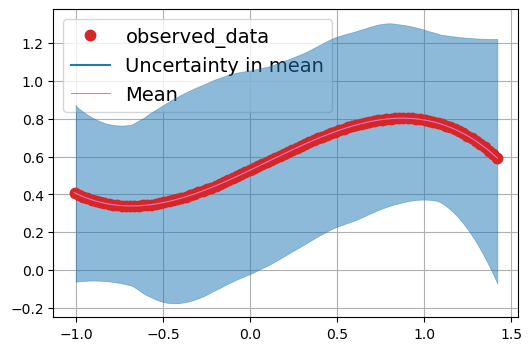

In [173]:
az.plot_lm(y=mu_mean, x=mass_seqx, y_model=mu, kind_pp="hdi", kind_model="hdi");

In [55]:
mass_4 = d[['mass_std', 'mass_std_2', 'mass_std_3', 'mass_std_4']].to_numpy()

In [56]:
jd_74 = gen_model(mass_4)

In [57]:
jd_74_pd = jd_74.experimental_pin(brain_std=d.brain_std.values)

In [58]:
def target_log_prob_74(*states):
    return jd_74_pd.unnormalized_log_prob(states)

@jax.jit
def sample_post_74(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_74, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [59]:
num_chains = 4
init_state_74 = jd_74_pd.sample_unpinned(num_chains, seed=key())

In [60]:
post_74 = sample_post_74(init_state_74, key())

In [61]:
post_74_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_74._asdict().items()}
dict_74 = dict(posterior=post_74_dict,
                 dims={"beta": ["coef"]},
                 coords={"coef": ['1', '2', '3', '4']})
idata_74 = az.from_dict(**dict_74)

In [62]:
az.summary(idata_74)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.764,0.543,-0.321,1.828,0.079,0.056,49.0,134.0,1.07
beta[1],0.766,0.804,-1.043,2.196,0.115,0.082,45.0,154.0,1.08
beta[2],-0.795,1.621,-3.967,2.449,0.289,0.206,32.0,73.0,1.10
beta[3],-0.692,0.975,-2.549,1.358,0.155,0.111,38.0,136.0,1.09
beta[4],0.583,1.085,-1.372,2.913,0.196,0.140,31.0,83.0,1.10
sigma,0.373,0.248,0.094,0.772,0.015,0.010,308.0,500.0,1.00


In [63]:
mass_5 = d[['mass_std', 'mass_std_2', 'mass_std_3',
            'mass_std_4', 'mass_std_5']].to_numpy()

In [64]:
jd_75 = gen_model(mass_5)
jd_75_pd = jd_75.experimental_pin(brain_std=d.brain_std.values)

In [65]:
def target_log_prob_75(*states):
    return jd_75_pd.unnormalized_log_prob(states)

@jax.jit
def sample_post_75(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_75, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [66]:
num_chains = 4
init_state_75 = jd_75_pd.sample_unpinned(num_chains, seed=key())
post_75 = sample_post_75(init_state_75, key())

In [67]:
post_75_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_75._asdict().items()}
dict_75 = dict(posterior=post_75_dict,
                 dims={"beta": ["coef"]},
                 coords={"coef": ['1', '2', '3', '4', '5']})
idata_75 = az.from_dict(**dict_75)

In [68]:
az.summary(idata_75)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.741,0.421,-0.100,1.566,0.051,0.053,48.0,197.0,1.20
beta[1],2.282,2.565,-1.021,6.285,1.186,0.966,6.0,39.0,1.71
beta[2],2.012,4.809,-2.506,10.081,2.322,1.828,7.0,157.0,1.54
beta[3],-0.683,2.427,-4.782,4.350,0.626,0.451,16.0,37.0,1.20
beta[4],-0.657,2.149,-3.913,2.093,0.939,0.722,7.0,4.0,1.54
beta[5],3.220,5.333,-2.012,12.217,2.602,2.032,7.0,43.0,1.68
sigma,0.287,0.282,0.039,0.777,0.072,0.052,8.0,4.0,1.49


In [69]:
mass_6 = d[['mass_std', 'mass_std_2', 'mass_std_3',
            'mass_std_4', 'mass_std_5', 'mass_std_6']].to_numpy()

In [70]:
jd_76 = gen_model(mass_6)
jd_76_pd = jd_76.experimental_pin(brain_std=d.brain_std.values)

In [71]:
def target_log_prob_76(*states):
    return jd_76_pd.unnormalized_log_prob(states)

# @jax.jit
def sample_post_76(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_76, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=1000,
        trace_fn=None, seed=seed)

In [72]:
num_chains = 4
init_state_76 = jd_76_pd.sample_unpinned(num_chains, seed=key())
post_76 = sample_post_76(init_state_76, key())

In [73]:
post_76_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_76._asdict().items()}
dict_76 = dict(posterior=post_76_dict,
                 dims={"beta": ["coef"]},
                 coords={"coef": ['1', '2', '3', '4', '5', '6']})
idata_76 = az.from_dict(**dict_76)

In [74]:
az.summary(idata_76)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.481,0.598,-0.478,1.788,0.199,0.145,11.0,16.0,1.83
beta[1],2.668,3.530,-1.394,8.283,1.680,1.329,6.0,30.0,1.95
beta[2],-0.648,4.411,-6.606,5.650,2.026,1.532,6.0,4.0,1.90
beta[3],0.256,3.403,-6.832,6.527,1.253,0.923,8.0,14.0,1.47
beta[4],-1.281,5.309,-9.985,7.741,2.357,1.773,6.0,18.0,1.98
beta[5],2.341,5.399,-3.569,11.044,2.603,2.042,5.0,39.0,2.09
beta[6],1.112,2.141,-2.639,5.091,0.895,0.669,6.0,16.0,1.83
sigma,0.351,0.344,0.023,0.883,0.051,0.036,81.0,102.0,1.38


### 7.2.3 From entropy to accuracy

### 7.2.4 Estimating divergence

##### Code 7.13

# BUG: jd.sample_distributions(value) works only with zero dim values  

In [15]:
jd_71.sample_distributions(value=[0.0, -0.2, 6.1], seed=key())

(StructTuple(
   alpha=<tfp.distributions.Normal 'alpha' batch_shape=[] event_shape=[] dtype=float32>,
   beta=<tfp.distributions.Normal 'beta' batch_shape=[] event_shape=[] dtype=float32>,
   log_sigma=<tfp.distributions.Normal 'log_sigma' batch_shape=[] event_shape=[] dtype=float32>,
   brain_std=<tfp.distributions.Normal 'brain_std' batch_shape=[7] event_shape=[] dtype=float32>
 ),
 StructTuple(
   alpha=Array(0., dtype=float32),
   beta=Array(-0.2, dtype=float32),
   log_sigma=Array(6.1, dtype=float32),
   brain_std=Array([ 726.3438 , -742.3146 , -258.90024,   83.36224,  274.41556,
            -126.8707 ,  676.07635], dtype=float32)
 ))

In [16]:
StateTuple = namedtuple('StateTuple', ['alpha', 'beta', 'sigma'])
jd_71.sample_distributions(value=StateTuple(0.0, -0.2, 6.1), seed=key())

(StructTuple(
   alpha=<tfp.distributions.Normal 'alpha' batch_shape=[] event_shape=[] dtype=float32>,
   beta=<tfp.distributions.Normal 'beta' batch_shape=[] event_shape=[] dtype=float32>,
   log_sigma=<tfp.distributions.Normal 'log_sigma' batch_shape=[] event_shape=[] dtype=float32>,
   brain_std=<tfp.distributions.Normal 'brain_std' batch_shape=[7] event_shape=[] dtype=float32>
 ),
 StructTuple(
   alpha=Array(0., dtype=float32),
   beta=Array(-0.2, dtype=float32),
   log_sigma=Array(6.1, dtype=float32),
   brain_std=Array([-711.87915 ,  186.92088 ,  319.87506 ,  437.5431  ,  144.0621  ,
            -202.03775 ,    6.832624], dtype=float32)
 ))

In [64]:
# jd_71.sample_distributions(value=[[0.0, 0.0], [-0.2, 0.0], [6.1, 5.4]], seed=key())
jd_71.sample_distributions(value=StateTuple([0.0, 0.0], [-0.2, 0.0], [6.1, 5.4]), seed=key())

ValueError: Attempt to convert a value (<object object at 0x321ac2350>) with an unsupported type (<class 'object'>) to a Tensor.

In [ ]:
# # In a better world. intuitive and elegant
# ds, samples = jd_71.sample_distributions(value=post_71, seed=key())
# ll = ds[-1].log_prob(d.brain_std.values) # (draw, chain, 7)
# # lppd
# jax.scipy.special.logsumexp(ll[:,0,:], b=1/draw, axis=0) # first chain or
# jax.scipy.special.logsumexp(ll, b=1/(draw*chain), axis=[0, 1]) 

## 7.3 Golem Taming: Regularization

## 7.4 Predicting predictive accuracy

### Overthinking: WAIC calculations

##### Code 7.19

In [120]:
# There is no CSV file for cars dataset in author's repo
# hence I have inlined the data. In R this dataset much be bundled in
# and this is why his code snippets do not need the csv file

cars_data = """
"","speed","dist"
"1",4,2
"2",4,10
"3",7,4
"4",7,22
"5",8,16
"6",9,10
"7",10,18
"8",10,26
"9",10,34
"10",11,17
"11",11,28
"12",12,14
"13",12,20
"14",12,24
"15",12,28
"16",13,26
"17",13,34
"18",13,34
"19",13,46
"20",14,26
"21",14,36
"22",14,60
"23",14,80
"24",15,20
"25",15,26
"26",15,54
"27",16,32
"28",16,40
"29",17,32
"30",17,40
"31",17,50
"32",18,42
"33",18,56
"34",18,76
"35",18,84
"36",19,36
"37",19,46
"38",19,68
"39",20,32
"40",20,48
"41",20,52
"42",20,56
"43",20,64
"44",22,66
"45",23,54
"46",24,70
"47",24,92
"48",24,93
"49",24,120
"50",25,85
"""

buffer = StringIO(cars_data)
d = pd.read_csv(buffer, sep=",")

d.head()

,Unnamed: 0,speed,dist
0,1,4,2
1,2,4,10
2,3,7,4
3,4,7,22
4,5,8,16


In [121]:
d = d.astype('float32')
d.dtypes

Unnamed: 0    float32
speed         float32
dist          float32
dtype: object

In [25]:
def model_cars(speed):
    def _generator():
        a = yield tfd.Normal(loc=0.0, scale=100.0, name="a")
        b = yield tfd.Normal(loc=0.0, scale=10.0, name="b")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = a + b * speed
        # BUG: DO NOT USE 'dist' as a name!!!! 
        yield tfd.Normal(loc=mu, scale=sigma, name="distance")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=False)

In [26]:
jd_cars = model_cars(speed=d.speed.values)
jd_cars_pd = jd_cars.experimental_pin(distance=d.dist.values)

In [76]:
def target_log_prob_cars(*states):
    return jd_cars_pd.unnormalized_log_prob(states)

@jax.jit
def sample_post_cars(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_cars, 1e-3)
  
    return tfp.mcmc.sample_chain(
        num_results=1000,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=2000,
        trace_fn=None, seed=seed)

In [65]:
# # too braod prior for 'a'
# num_chains = 4
# init_state_cars = jd_cars_pd.sample_unpinned(num_chains, seed=key())
# post_cars = sample_post_cars(init_state_cars, key())

In [69]:
state_name_cars = jd_cars_pd.sample_unpinned(seed=key())._fields
StateTuple = namedtuple("StateTuple", state_name_cars)

In [83]:
num_chains = 4
init_state_cars = [jnp.ones(num_chains), 
                   jnp.ones(num_chains), jnp.ones(num_chains)]
init_state_cars = StateTuple(**dict(zip(state_name_cars, init_state_cars)))
post_cars = sample_post_cars(init_state_cars, key())

In [84]:
post_cars_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_cars._asdict().items()}
dict_cars = dict(posterior=post_cars_dict)
idata_cars = az.from_dict(**dict_cars)

In [85]:
az.summary(idata_cars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-17.777,5.456,-28.257,-8.578,1.890,1.439,8.0,25.0,1.45
b,3.944,0.337,3.301,4.542,0.110,0.081,9.0,29.0,1.37
sigma,13.867,1.191,11.714,16.105,0.082,0.058,208.0,393.0,1.03


In [86]:
from sklearn.linear_model import LinearRegression

In [88]:
m = LinearRegression()
m.fit(d.speed.values.reshape(-1, 1), d.dist.values)

LinearRegression()

In [89]:
print(f"intercept: {m.intercept_}")
print(f"slope: {m.coef_}")

intercept: -17.579082489013672
slope: [3.932408]


##### Code 7.20

In [161]:
# idata_cars.posterior['a']: (chain, draw)
# mu: (chain, draw, obs)
mu = idata_cars.posterior['a'] + idata_cars.posterior['b'] * xr.DataArray(d.speed.values)
mu = mu.to_numpy()
# add newaxis to braodcast through obs
sigma = idata_cars.posterior['sigma'].to_numpy()[..., np.newaxis]

In [164]:
normal = tfd.Normal(loc=mu, scale=sigma)

In [265]:
# (chain, draw, obs)
ll_i = normal.log_prob(d.dist.values)

In [ ]:
# from source: /arviz/stats/stats.py: def waic() ...
# 
# waic_i = scale_value * (lppd_i - vars_lpd)
# waic_se = (n_data_points * np.var(waic_i.values)) ** 0.5
# waic_sum = np.sum(waic_i.values)
# p_waic = np.sum(vars_lpd.values)

In [272]:
lppd_i = jax.scipy.special.logsumexp(ll_i, b=1/4000, axis=(0, 1))
vars_lpd = jnp.var(ll_i, axis=(0, 1))
waic_i = -2*(lppd_i - vars_lpd)
print(f"elpd_waic: {jnp.sum(waic_i)}, se:{jnp.sqrt(len(obs) * jnp.var(waic_i))}")
print(f"p_wais: {jnp.sum(vars_lpd)}")

elpd_waic: 420.5662841796875, se:15.613472938537598
p_wais: 3.6938436031341553


In [273]:
dict_cars.update(log_likelihood={'ll': ll_i},
                 dims={"ll": ["obs"]},
                 coords={"obs": jnp.arange(len(d.dist.values))})
idata_cars = az.from_dict(**dict_cars)

In [274]:
az.waic(idata_cars, scale='deviance')

/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 50 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   420.57    15.94
p_waic            3.69        -

There has been a warning during the calculation. Please check the results.

In [207]:
# UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
# See http://arxiv.org/abs/1507.04544 for details
ll_vars = jnp.var(ll_i, axis=(0, 1))
ll_vars[jnp.where(ll_vars > 0.4)]

Array([0.7092146, 1.2408626], dtype=float32)

In [275]:
# az.waic() without waning cases 
obs = jnp.where(ll_vars <= 0.4)[0]
ll_i = ll_i[..., obs]

In [276]:
dict_cars.update(log_likelihood={'ll': ll_i},
                 dims={"ll": ["obs"]},
                 coords={"obs": jnp.arange(len(obs))})
idata_cars = az.from_dict(**dict_cars)

In [277]:
az.waic(idata_cars, scale='deviance')

Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   384.62     7.95
p_waic            1.74        -

In [278]:
# by hand with the selected obs
lppd_i = jax.scipy.special.logsumexp(ll_i, b=1/4000, axis=(0, 1))
vars_lpd = jnp.var(ll_i, axis=(0, 1))

In [279]:
waic_i = -2*(lppd_i - vars_lpd)
# elpd_waic
print(f"elpd_waic: {jnp.sum(waic_i)}, se:{jnp.sqrt(len(obs) * jnp.var(waic_i))}")
print(f"p_wais: {jnp.sum(vars_lpd)}")

elpd_waic: 384.6249694824219, se:7.945420742034912
p_wais: 1.7437663078308105


### 7.4.3 Comparing CV, PSIS, and WAIC

## 7.5 Model comparison

##### Code 7.25


Here we need to first redefine models from the previous chapters i.e. m6_6,m6_7,m6_8 and compute the log likelihoods as well and only then we will compute the WAIC

In [282]:
def simulate():
    seed = tfp.util.SeedStream(613, salt="sim_heights")
    # number of plants
    N = 100
    # simulate initial heights
    h0 = tfd.Normal(loc=10.0, scale=2.0).sample(N, seed=seed())
    # assign treatments and simulate fungus and growth
    treatment = jnp.repeat(jnp.array([0.0, 1.0]), repeats=N // 2)
    fungus = tfd.Binomial(total_count=1.0, probs=(0.5 - treatment * 0.4)).sample(seed=seed())
    h1 = h0 + tfd.Normal(loc=5.0 - 3.0 * fungus, scale=1.0).sample(seed=seed())
    # compose a clean data frame
    return {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus}

d_dict = simulate()

In [283]:
d = pd.DataFrame.from_dict(d_dict)

In [285]:
def model_66(h0):
    def _generator():
        p = yield tfd.LogNormal(loc=0.0, scale=0.25, name="p")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = h0 * p
        h1 = yield tfd.Normal(loc=mu, scale=sigma, name="h1")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=False)

In [286]:
jd_66 = model_66(d.h0.values)
jd_66_pd = jd_66.experimental_pin(h1=d.h1.values)

In [291]:
def target_log_prob_66(*states):
    return jd_66_pd.unnormalized_log_prob(states)

def sample_post_66(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_66, 1e-3)
  
    return tfp.mcmc.sample_chain(
            num_results=1000,
            current_state=init_state,
            kernel=kernel,
            num_burnin_steps=2000,
            trace_fn=None, seed=seed)

In [292]:
num_chains = 4
init_state_66 = jd_66_pd.sample_unpinned(num_chains, seed=key())
post_66 = sample_post_66(init_state_66, key())

In [293]:
post_66_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_66._asdict().items()}
dict_66 = dict(posterior=post_66_dict)
idata_66 = az.from_dict(**dict_66)

In [294]:
az.summary(idata_66)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.411,0.018,1.377,1.444,0.000,0.000,2713.0,1816.0,1.00
sigma,1.869,0.141,1.615,2.130,0.006,0.005,520.0,542.0,1.01


The result shows that with height as the only predictor variable in the model there is about 40% growth on average.

##### Code 6.16

In this model we include treatment & fungus variables as well

In [295]:
def model_67(h0, treatment, fungus):
    def _generator():
        a = yield tfd.LogNormal(loc=0.0, scale=0.2, name="a")
        bt = yield tfd.Normal(loc=0.0, scale=0.5, name="bt")
        bf = yield tfd.Normal(loc=0.0, scale=0.5, name="bf")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        p = a + bt * treatment + bf * fungus
        mu = h0 * p
        yield tfd.Normal(loc=mu, scale=sigma, name="h1")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=False)

In [296]:
jd_67 = model_67(d.h0.values, d.treatment.values, d.fungus.values)
jd_67_pd = jd_67.experimental_pin(h1=d.h1.values)

In [297]:
def target_log_prob_67(*states):
    return jd_67_pd.unnormalized_log_prob(states)

def sample_post_67(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_67, 1e-2)
  
    return tfp.mcmc.sample_chain(
            num_results=1000,
            current_state=init_state,
            kernel=kernel,
            num_burnin_steps=1500,
            trace_fn=None, seed=seed)

In [ ]:
# num_chains = 4
# init_state_67 = jd_67_pd.sample_unpinned(num_chains, seed=key())

In [298]:
state_name_67 = jd_67_pd.sample_unpinned(seed=key())._fields

In [299]:
StateTuple = namedtuple("StateTuple", state_name_67)

In [300]:
num_chains = 4
init_state_67 = [jnp.ones(num_chains), jnp.zeros(num_chains), 
                 jnp.zeros(num_chains), jnp.ones(num_chains)]

In [301]:
init_state_67 = StateTuple(**dict(zip(state_name_67, init_state_67)))

In [302]:
post_67 = sample_post_67(init_state_67, key())

In [303]:
post_67_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_67._asdict().items()}

In [304]:
dict_67 = dict(posterior=post_67_dict)

In [305]:
idata_67 = az.from_dict(**dict_67)

In [306]:
az.summary(idata_67)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.493,0.023,1.451,1.536,0.000,0.000,2869.0,2715.0,1.0
bf,-0.326,0.033,-0.389,-0.264,0.001,0.000,2774.0,2663.0,1.0
bt,-0.015,0.028,-0.065,0.039,0.001,0.000,2888.0,2406.0,1.0
sigma,1.257,0.089,1.100,1.433,0.003,0.002,874.0,1226.0,1.0


In [307]:
def model_68(h0, treatment):
    def _generator():
        a = yield tfd.LogNormal(loc=0.0, scale=0.2, name="a")
        bt = yield tfd.Normal(loc=0.0, scale=0.5, name="bt")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        p = a + bt * treatment
        mu = h0 * p
        yield tfd.Normal(loc=mu, scale=sigma, name="h1")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [308]:
jd_68 = model_68(d.h0.values, d.treatment.values)

In [309]:
jd_68_pd = jd_68.experimental_pin(h1=d.h1.values)

In [310]:
def target_log_prob_68(*states):
    return jd_68_pd.unnormalized_log_prob(states)

In [311]:
def sample_post_68(init_state, seed):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_68, 1e-3)
  
    return tfp.mcmc.sample_chain(
            num_results=1000,
            current_state=init_state,
            kernel=kernel,
            num_burnin_steps=1500,
            trace_fn=None, seed=seed)

In [316]:
num_chains = 4
init_state_68 = jd_68_pd.sample_unpinned(num_chains, seed=key())

In [317]:
post_68 = sample_post_68(init_state_68, key())

In [318]:
post_68_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_68._asdict().items()}
dict_68 = dict(posterior=post_68_dict)
idata_68 = az.from_dict(**dict_68)

In [319]:
az.summary(idata_68)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.350,0.025,1.300,1.395,0.001,0.000,2540.0,2509.0,1.00
bt,0.119,0.035,0.053,0.188,0.001,0.001,2146.0,1969.0,1.00
sigma,1.772,0.126,1.554,2.029,0.005,0.004,625.0,683.0,1.01


In [320]:
mu_66 = idata_66.posterior['p'] * xr.DataArray(d.h0.values)
mu_66 = mu_66.to_numpy()
# add newaxis to braodcast through obs
sigma_66 = idata_66.posterior['sigma'].to_numpy()[..., np.newaxis]

normal_66 = tfd.Normal(loc=mu_66, scale=sigma_66)
ll_i_66 = normal_66.log_prob(d.h1.values)

dict_66 = dict(log_likelihood={'ll': ll_i_66},
               dims={"ll": ["obs"]},
               coords={"obs": jnp.arange(len(d.h1.values))})
idata_66 = az.from_dict(**dict_66)

In [329]:
mu_67 = (idata_67.posterior['a'] + \
         idata_67.posterior['bt'] * xr.DataArray(d.treatment.values) + \
         idata_67.posterior['bf'] * xr.DataArray(d.fungus.values)) * xr.DataArray(d.h0.values)
mu_67 = mu_67.to_numpy()
sigma_67 = idata_67.posterior['sigma'].to_numpy()[..., np.newaxis]

normal_67 = tfd.Normal(loc=mu_67, scale=sigma_67)
ll_i_67 = normal_67.log_prob(d.h1.values)

dict_67 = dict(log_likelihood={'ll': ll_i_67},
               dims={"ll": ["obs"]},
               coords={"obs": jnp.arange(len(d.h1.values))})
idata_67 = az.from_dict(**dict_67)

In [330]:
mu_68 = (idata_68.posterior['a'] + \
         idata_68.posterior['bt'] * xr.DataArray(d.treatment.values)) * xr.DataArray(d.h0.values)
mu_68 = mu_68.to_numpy()
sigma_68 = idata_68.posterior['sigma'].to_numpy()[..., np.newaxis]

normal_68 = tfd.Normal(loc=mu_68, scale=sigma_68)
ll_i_68 = normal_68.log_prob(d.h1.values)

dict_68 = dict(log_likelihood={'ll': ll_i_68},
               dims={"ll": ["obs"]},
               coords={"obs": jnp.arange(len(d.h1.values))})
idata_68 = az.from_dict(**dict_68)

##### Code 7.26

In [336]:
compare_df =az.compare(
    {"m6.6": idata_66, "m6.7": idata_67, "m6.8": idata_68},
    ic="waic", scale="deviance")
compare_df

/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m6.7,0,334.520512,4.425648,0.000000,0.954797,17.387366,0.000000,True,deviance
m6.8,1,402.415840,3.385741,67.895328,0.000000,14.534156,14.636170,True,deviance
m6.6,2,411.123234,2.299253,76.602721,0.045203,15.366604,18.044349,True,deviance


##### Code 7.27 

In [341]:
waic_66 = az.waic(idata_66, pointwise=True, scale="deviance")
waic_67 = az.waic(idata_67, pointwise=True, scale="deviance")
waic_68 = az.waic(idata_68, pointwise=True, scale="deviance")

diff_78 = waic_67.waic_i - waic_68.waic_i
jnp.sqrt(len(diff_78) * jnp.var(diff_78.to_numpy()))

/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jun/miniforge3/envs/dl/lib/python3.12/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Array(14.636169, dtype=float32)

##### Code 7.29

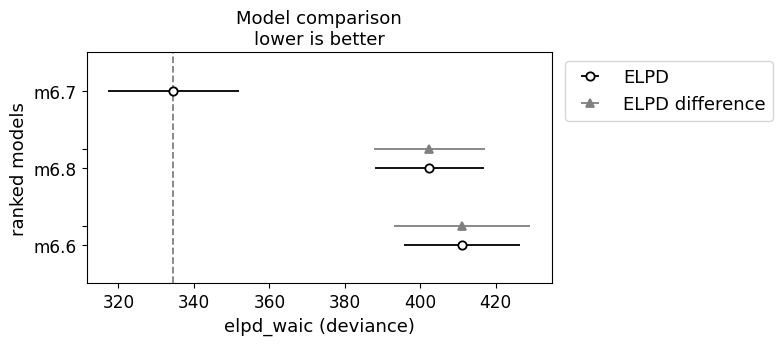

In [337]:
az.plot_compare(compare_df);

##### Code 7.31

In [342]:
dSE = lambda waic1, waic2: np.sqrt(
    len(waic1.waic_i) * np.var(waic1.waic_i.to_numpy() - waic2.waic_i.to_numpy())
)
data = {"m6.6": waic_66, "m6.7": waic_67, "m6.8": waic_68}
pd.DataFrame(
    {
        row: {col: dSE(row_val, col_val) for col, col_val in data.items()}
        for row, row_val in data.items()
    }
)

,m6.6,m6.7,m6.8
m6.6,0.000000,18.044349,7.020422
m6.7,18.044349,0.000000,14.636170
m6.8,7.020422,14.636170,0.000000


### 7.5.2 Outliers and other illusions

In [66]:
# az.compare(compare_dict, ic="loo", scale="deviance")